In [1]:
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

## Preprocessing Data

In [2]:
np.random.seed(100)

fundamentals = pd.read_csv('../data/stocks_data_fundamentals.csv',index_col=0, parse_dates=True)

fundamentals['dates'] = pd.to_datetime(fundamentals['dates'],format='%b %y')

stocks = fundamentals['stocks'].unique()

for stock in tqdm(stocks):
    
    df = fundamentals.loc[fundamentals['stocks'] == stock]
    df.replace(0,df.median(axis=1),inplace=True)
    fundamentals.loc[df.index, :] = df

  0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
fundamentals

,stocks,dates,BasicEPS,DilutedEPS,CashEPS,DivPS,OpRev,NPS,ROCE,NPMargin,...,ROE2Networth,EntValue,EntValuePerNetSales,Price2Book,Price2Sales,RetentionRatios,EarningYield,AssetTurnRatio,EVPerEBITDA,PBDITMargin
0,SBI,2021-03-01,22.87,22.87,26.59,4.0,297.10,22.87,1.64,7.69,...,8.86,4210541.48,15.88,1.41,1.23,82.50,0.06,---,---,---
1,SBI,2020-03-01,16.23,16.23,19.94,0.0,288.33,16.23,1.79,5.63,...,6.95,3565310.84,13.86,0.84,0.68,100.00,0.08,---,---,---
2,SBI,2019-03-01,0.97,0.97,0.97,0.0,272.13,0.97,0.00,0.35,...,0.39,3423771.88,14.10,1.30,1.18,100.00,0.00,---,---,---
3,SBI,2018-03-01,-7.67,-7.67,-4.07,0.0,247.07,-7.34,1.81,-2.96,...,-3.37,3141292.12,14.25,1.15,1.01,100.00,-0.03,---,---,---
4,SBI,2017-03-01,13.43,13.43,16.02,2.6,220.13,13.15,1.99,5.97,...,6.69,2467752.16,14.06,1.49,1.33,79.88,0.04,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,HEROMOTOCO,2016-03-01,156.86,156.86,178.96,72.0,1432.11,156.85,37.77,10.95,...,39.42,58648.34,2.05,7.40,2.06,54.10,0.05,231.74,12.12,16.91
496,HEROMOTOCO,2015-03-01,119.46,119.46,146.50,60.0,1381.34,119.46,35.93,8.64,...,36.47,52613.47,1.91,8.07,1.91,49.77,0.05,262.17,13.04,14.62
497,HEROMOTOCO,2014-03-01,105.61,105.61,161.06,65.0,1265.67,105.61,37.16,8.34,...,37.66,45271.31,1.79,8.11,1.80,38.40,0.05,250.31,11.36,15.77
498,HEROMOTOCO,2013-03-01,106.07,106.07,163.24,60.0,1190.19,106.07,38.71,8.91,...,42.31,30912.86,1.30,6.15,1.30,43.43,0.07,246.51,8.39,15.49


In [4]:
fundamentals.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,BasicEPS,DilutedEPS,CashEPS,DivPS,OpRev,NPS,ROCE,NPMargin,ROA,ROE2Networth,EntValue,EntValuePerNetSales,Price2Book,Price2Sales,RetentionRatios,EarningYield
BasicEPS,1.000,1.000,0.943,0.646,0.706,0.985,0.233,-0.046,0.233,0.184,-0.066,-0.075,0.137,-0.070,0.022,0.068
DilutedEPS,1.000,1.000,0.943,0.647,0.707,0.985,0.233,-0.046,0.233,0.184,-0.066,-0.074,0.137,-0.070,0.022,0.068
CashEPS,0.943,0.943,1.000,0.610,0.766,0.957,0.176,-0.052,0.176,0.120,-0.086,-0.081,0.101,-0.076,0.026,0.039
DivPS,0.646,0.647,0.610,1.000,0.515,0.659,0.447,0.012,0.392,0.435,-0.076,-0.019,0.501,-0.010,-0.091,0.009
OpRev,0.706,0.707,0.766,0.515,1.000,0.722,0.094,-0.087,0.055,0.049,-0.095,-0.128,0.038,-0.120,0.023,0.097
NPS,0.985,0.985,0.957,0.659,0.722,1.000,0.245,-0.046,0.244,0.193,-0.063,-0.074,0.144,-0.069,0.027,0.075
ROCE,0.233,0.233,0.176,0.447,0.094,0.245,1.000,0.348,0.900,0.874,-0.135,0.277,0.614,0.294,-0.121,0.048
NPMargin,-0.046,-0.046,-0.052,0.012,-0.087,-0.046,0.348,1.000,0.545,0.395,-0.018,0.883,0.058,0.885,-0.077,0.090
ROA,0.233,0.233,0.176,0.392,0.055,0.244,0.900,0.545,1.000,0.823,-0.148,0.462,0.433,0.478,-0.092,0.148
ROE2Networth,0.184,0.184,0.120,0.435,0.049,0.193,0.874,0.395,0.823,1.000,-0.095,0.315,0.654,0.324,-0.082,0.145


In [5]:
fundamentals = fundamentals[['stocks','dates','NPS','ROCE','NPMargin','EntValue','Price2Book','RetentionRatios','EarningYield']]

fundamentals = fundamentals.sort_values(by=['stocks','dates']).reset_index(drop=True)

#fundamentals['NPS_Prcnt_change'] = fundamentals.groupby(['stocks']).NPS.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['ROCE_Prcnt_change'] = fundamentals.groupby(['stocks']).ROCE.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['NPMargin_Prcnt_change'] = fundamentals.groupby(['stocks']).NPMargin.pct_change(periods=1).apply(lambda x: x*100)
fundamentals['EntValue_Prcnt_change'] = fundamentals.groupby(['stocks']).EntValue.pct_change(periods=1).apply(lambda x: x*100)
fundamentals['Price2Book_Prcnt_change'] = fundamentals.groupby(['stocks']).Price2Book.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['RetentionRatios_Prcnt_change'] = fundamentals.groupby(['stocks']).RetentionRatios.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['EarningYield_Prcnt_change'] = fundamentals.groupby(['stocks']).EarningYield.pct_change(periods=1).apply(lambda x: x*100)

In [6]:
fundamentals = fundamentals.sort_values(by=['stocks','dates'],ascending=False).reset_index(drop=True)

from statsmodels.stats.outliers_influence import variance_inflation_factor

X = fundamentals[['NPS','ROCE','NPMargin','EntValue','Price2Book','RetentionRatios','EarningYield']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,NPS,1.528040
1,ROCE,4.123242
2,NPMargin,1.239180
3,EntValue,1.176932
4,Price2Book,2.726149
5,RetentionRatios,1.372575
6,EarningYield,1.888066


In [7]:
def label(df):
    """
    Creates classes of:
    - buy(1)
    - sell(0)
    
    Threshold can be changed to fit whatever price change is desired
    """
    result = score(df)
    
    if result >= 4:
        return 1
    else:
        return 0

def score(df,thres=12):
    result = 0
    if df['NPS'] >= thres :
        result += 1
    if df['ROCE'] >= thres :
        result += 1
    if df['NPMargin'] >= thres :
        result += 1
    if df['EntValue_Prcnt_change'] >= thres :
        result += 1
    if df['Price2Book_Prcnt_change'] >= thres :
        result += 1
    if df['RetentionRatios'] >= thres :
        result += 1
    if df['EarningYield'] >= thres :
        result += 1
    return result


In [8]:
fundamentals['Label'] = 0.0
fundamentals['Score'] = 0.0

for stock in tqdm(stocks):
    # Assigning the the new DF
    new_df = fundamentals[fundamentals['stocks'] == stock]
    
    new_df['Label'] = new_df.apply(label, axis=1)#.shift(-1)
    new_df['Score'] = new_df.apply(score, axis=1)#.shift(-1)
    
    fundamentals.loc[new_df.index, :] = new_df[:]

fundamentals = fundamentals.dropna()

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
fundamentals[fundamentals['stocks'] == 'SBI']

,stocks,dates,NPS,ROCE,NPMargin,EntValue,Price2Book,RetentionRatios,EarningYield,EntValue_Prcnt_change,Price2Book_Prcnt_change,Label,Score
120,SBI,2021-03-01,22.87,1.64,7.69,4210541.48,1.41,82.50,0.06,18.097458,67.857143,1.0,4.0
121,SBI,2020-03-01,16.23,1.79,5.63,3565310.84,0.84,100.00,0.08,4.134007,-35.384615,0.0,2.0
122,SBI,2019-03-01,0.97,0.00,0.35,3423771.88,1.30,100.00,0.00,8.992470,13.043478,0.0,2.0
123,SBI,2018-03-01,-7.34,1.81,-2.96,3141292.12,1.15,100.00,-0.03,27.293663,-22.818792,0.0,2.0
124,SBI,2017-03-01,13.15,1.99,5.97,2467752.16,1.49,79.88,0.04,18.912431,41.904762,1.0,4.0
125,SBI,2016-03-01,12.82,1.96,6.06,2075268.45,1.05,79.71,0.07,11.250902,-32.258065,0.0,2.0
126,SBI,2015-03-01,17.55,2.06,8.59,1865394.71,1.55,79.78,0.07,-36.220041,-87.200661,0.0,2.0
127,SBI,2014-03-01,14.59,1.89,7.98,2924734.90,12.11,79.43,0.01,102.001890,746.853147,1.0,4.0
128,SBI,2013-03-01,206.20,2.11,11.78,1447875.02,1.43,79.87,0.10,15.170225,-14.371257,0.0,3.0


In [10]:
fundamentals.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,NPS,ROCE,NPMargin,EntValue,Price2Book,RetentionRatios,EarningYield,EntValue_Prcnt_change,Price2Book_Prcnt_change,Label,Score
NPS,1.000,0.240,-0.045,-0.083,0.139,0.027,0.055,0.006,-0.059,0.230,0.274
ROCE,0.240,1.000,0.360,-0.151,0.600,-0.116,0.043,0.006,-0.027,0.344,0.435
NPMargin,-0.045,0.360,1.000,-0.021,0.055,-0.074,0.097,-0.085,-0.025,-0.011,0.017
EntValue,-0.083,-0.151,-0.021,1.000,-0.070,0.052,-0.026,0.008,0.168,0.006,-0.011
Price2Book,0.139,0.600,0.055,-0.070,1.000,-0.087,-0.272,0.167,0.144,0.184,0.255
RetentionRatios,0.027,-0.116,-0.074,0.052,-0.087,1.000,0.088,-0.017,-0.030,0.068,0.092
EarningYield,0.055,0.043,0.097,-0.026,-0.272,0.088,1.000,-0.238,-0.206,-0.013,0.092
EntValue_Prcnt_change,0.006,0.006,-0.085,0.008,0.167,-0.017,-0.238,1.000,0.693,0.288,0.430
Price2Book_Prcnt_change,-0.059,-0.027,-0.025,0.168,0.144,-0.030,-0.206,0.693,1.000,0.208,0.287
Label,0.230,0.344,-0.011,0.006,0.184,0.068,-0.013,0.288,0.208,1.000,0.821


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = fundamentals.drop(columns=['Label','Score','stocks','dates','EntValue'], axis=1)
X = X.replace((np.inf, -np.inf, np.nan), 0)
y = fundamentals.Label

scaler = StandardScaler()

scaler.fit_transform(X)

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=50,shuffle=True,train_size=0.7)

pre_optimization_precision = []
post_optimization_precision = []
pre_optimization_accuracy = []
post_optimization_accuracy = []

In [12]:
# Importing the model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Fitting and training
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [13]:
# Classifier predictions
AdaBoost_pred = AdaBoost_clf.predict(X_test)

#Printing out results
AdaBoost_report = classification_report(y_test, AdaBoost_pred)
print(AdaBoost_report)

pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=AdaBoost_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=AdaBoost_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        72

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132



In [14]:
# Parameters to Tune
params = {'n_estimators': [50, 100, 200, 500, 600 , 700],
          'learning_rate': [1, .1, .01]}

AdaBoost_search = GridSearchCV(AdaBoost_clf, params, cv=5, return_train_score=True, verbose=5, scoring='f1_macro')

AdaBoost_search.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=1, n_estimators=50;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END learning_rate=1, n_estimators=50;, score=(train=1.000, test=0.965) total time=   0.0s
[CV 3/5] END learning_rate=1, n_estimators=50;, score=(train=1.000, test=0.988) total time=   0.0s
[CV 4/5] END learning_rate=1, n_estimators=50;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=1, n_estimators=50;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.931) total time=   0.0s
[CV 3/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.988) total time=   0.1s
[CV 4/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=1, n_estimators=1

[CV 2/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.968, test=0.930) total time=   0.7s
[CV 3/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.953, test=0.784) total time=   0.7s
[CV 4/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.974, test=0.988) total time=   0.7s
[CV 5/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.983, test=0.892) total time=   0.7s
[CV 1/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.965, test=0.965) total time=   0.8s
[CV 2/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.977, test=0.930) total time=   0.8s
[CV 3/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.959, test=0.797) total time=   0.8s
[CV 4/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.991, test=1.000) total time=   0.8s
[CV 5/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.985, test=0.892) total time=   0.8s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [50, 100, 200, 500, 600, 700]},
             return_train_score=True, scoring='f1_macro', verbose=5)

In [15]:
print("Best Accuracy: %f using %s" % (AdaBoost_search.best_score_, AdaBoost_search.best_params_))
print("Mean Training Score:", np.mean(AdaBoost_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", AdaBoost_search.score(X, y))
print("\nBest Parameter Found:")
AdaBoost_search.best_params_

Best Accuracy: 0.990721 using {'learning_rate': 1, 'n_estimators': 50}
Mean Training Score: 0.9718392771651936
Mean Testing Score: 1.0

Best Parameter Found:


{'learning_rate': 1, 'n_estimators': 50}

In [16]:
AdaBoost_search = AdaBoost_search.best_estimator_

AdaBoost_search.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1)

In [17]:
# Classifier predictions
AdaBoost_pred = AdaBoost_search.predict(X_test)

#Printing out results
AdaBoost_report = classification_report(y_test, AdaBoost_pred)
print(AdaBoost_report)

post_optimization_precision.append(precision_score(y_true=y_test, y_pred=AdaBoost_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=AdaBoost_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        72

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132



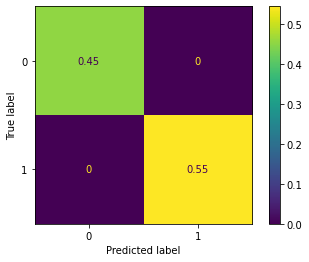

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AdaBoost_cm = confusion_matrix(y_test, AdaBoost_pred, normalize='all')
AdaBoost_cmd = ConfusionMatrixDisplay(AdaBoost_cm)
AdaBoost_cmd.plot()

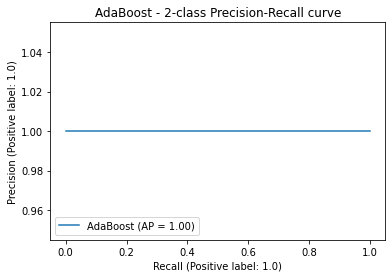

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    AdaBoost_search, X_test, y_test, name="AdaBoost"
)
_ = display.ax_.set_title("AdaBoost - 2-class Precision-Recall curve")

In [20]:
# Importing the model
from sklearn.linear_model import LogisticRegression

# Fitting and training
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Classifier predictions
LogReg_pred = LogReg_clf.predict(X_test)

#Printing out results
LogReg_report = classification_report(y_test, LogReg_pred)
print(LogReg_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=LogReg_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=LogReg_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68        60
         1.0       0.74      0.71      0.72        72

    accuracy                           0.70       132
   macro avg       0.70      0.70      0.70       132
weighted avg       0.71      0.70      0.71       132



In [22]:
# Parameters to Tune
params = {'penalty': ['l1', 'l2'],
          'C': [1.5**n for n in range(0, 20, 5)],
          'fit_intercept': [True, False],
          'intercept_scaling': [0.01, 0.1, 1, 10, 50, 100],
          'solver': ['liblinear', 'saga']}

LogReg_search = GridSearchCV(LogReg_clf, params, cv=5, return_train_score=True, verbose=5, scoring='f1_macro')

LogReg_search.fit(X,y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.703, test=0.607) total time=   0.0s
[CV 2/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.647, test=0.712) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.674, test=0.517) total time=   0.0s
[CV 4/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.649, test=0.691) total time=   0.0s
[CV 5/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.759, test=0.706) total time=   0.0s
[CV 1/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=1.0, fit_intercept=True, intercept_scaling=0.01, pe

[CV 2/5] END C=1.0, fit_intercept=True, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=True, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=1.0, fit_intercept=True, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=1.0, fit_intercept=True, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=1.0, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=liblinear;, score=(train=0.718, test=0.787) total time=   0.0s
[CV 2/5] END C=1.0, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=liblinear;, score=(train=0.739, test=0.716) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=liblinear;, score=(train=0.781, test=0.589) total time=   0.0s
[CV 4/5] END

[CV 4/5] END C=1.0, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=1.0, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=saga;, score=(train=0.637, test=0.590) total time=   0.0s
[CV 1/5] END C=1.0, fit_intercept=False, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.703, test=0.607) total time=   0.0s
[CV 2/5] END C=1.0, fit_intercept=False, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.647, test=0.712) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=False, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.674, test=0.517) total time=   0.0s
[CV 4/5] END C=1.0, fit_intercept=False, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.649, test=0.691) total time=   0.0s
[CV 5/5] END C=1.0, fit_intercept=False, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.759, test=0.706) total

[CV 2/5] END C=1.0, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=1.0, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=1.0, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=1.0, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=liblinear;, score=(train=0.703, test=0.607) total time=   0.0s
[CV 2/5] END C=1.0, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=liblinear;, score=(train=0.647, test=0.712) total time=   0.0s
[CV 3/5] END C=1.0, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=liblinear;, score=(train=0.674, test=0.517) total time=   0.0s
[C

[CV 5/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=liblinear;, score=(train=0.814, test=0.754) total time=   0.2s
[CV 1/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=7.59375, fit_intercept=True, intercept_scaling=1, penalty=l2, solver=liblinear;, score=(train=0.723, test=0.763) total time=   0

[CV 5/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=liblinear;, score=(train=0.811, test=0.754) total time=   0.2s
[CV 1/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=7.59375, fit_intercept=True, intercept_scaling=100, penalty=l2, solver=liblinear;, score=(train=0.718, test=0.787) t

[CV 2/5] END C=7.59375, fit_intercept=False, intercept_scaling=1, penalty=l2, solver=saga;, score=(train=0.461, test=0.437) total time=   0.0s
[CV 3/5] END C=7.59375, fit_intercept=False, intercept_scaling=1, penalty=l2, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=7.59375, fit_intercept=False, intercept_scaling=1, penalty=l2, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=7.59375, fit_intercept=False, intercept_scaling=1, penalty=l2, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=7.59375, fit_intercept=False, intercept_scaling=10, penalty=l1, solver=liblinear;, score=(train=0.723, test=0.572) total time=   0.0s
[CV 2/5] END C=7.59375, fit_intercept=False, intercept_scaling=10, penalty=l1, solver=liblinear;, score=(train=0.676, test=0.739) total time=   0.0s
[CV 3/5] END C=7.59375, fit_intercept=False, intercept_scaling=10, penalty=l1, solver=liblinear;, score=(train=0.717, test=0.622) 

[CV 5/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.808, test=0.754) total time=   0.2s
[CV 1/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=0.01, penalty=l2, sol

[CV 5/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=liblinear;, score=(train=0.811, test=0.754) total time=   0.2s
[CV 1/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=57.6650390625, fit_intercept=True, intercept_scaling=10, penalty=l2, solver=liblinear;

[CV 5/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=liblinear;, score=(train=0.720, test=0.572) total time=   0.0s
[CV 2/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=liblinear;, score=(train=0.675, test=0.747) total time=   0.0s
[CV 3/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=liblinear;, score=(train=0.708, test=0.622) total time=   0.0s
[CV 4/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=liblinear;, score=(train=0.683, test=0.719) total time=   0.0s
[CV 5/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=0.01, penalty=l2, solver=liblinear;, score=(train=0.751, test=0.686) total time=   0.0s
[CV 1/5] END C=57.6650390625, fit_intercept=False, intercept_sc

[CV 3/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=liblinear;, score=(train=0.720, test=0.572) total time=   0.0s
[CV 2/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=liblinear;, score=(train=0.675, test=0.747) total time=   0.0s
[CV 3/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l2, solver=liblinear;, score=(train=0.708, test=0.622) total time=   0.0s
[CV 4/5] END C=57.6650390625, fit_intercept=False, intercept_scaling=50, penalty=l2, 

[CV 5/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=liblinear;, score=(train=0.815, test=0.754) total time=   0.2s
[CV 1/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=saga;, score=(train=0.467, test=0.437) total time=   0.0s
[CV 3/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=0.1, penalty=l1, solver=saga;, score=(train=0.633, test=0.599) total time=   0.0s
[CV 1/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling

[CV 5/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=liblinear;, score=(train=0.808, test=0.754) total time=   0.2s
[CV 1/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.461, test=0.437) total time=   0.0s
[CV 3/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, penalty=l1, solver=saga;, score=(train=0.637, test=0.599) total time=   0.0s
[CV 1/5] END C=437.8938903808594, fit_intercept=True, intercept_scaling=50, p

[CV 3/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=liblinear;, score=(train=0.708, test=0.622) total time=   0.0s
[CV 4/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=liblinear;, score=(train=0.686, test=0.719) total time=   0.0s
[CV 5/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=liblinear;, score=(train=0.737, test=0.702) total time=   0.0s
[CV 1/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.527, test=0.553) total time=   0.0s
[CV 2/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.461, test=0.437) total time=   0.0s
[CV 3/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=437.8938903808594, fit_intercept=False, 

[CV 2/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.461, test=0.437) total time=   0.0s
[CV 3/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.520, test=0.461) total time=   0.0s
[CV 4/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.507, test=0.497) total time=   0.0s
[CV 5/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l1, solver=saga;, score=(train=0.637, test=0.590) total time=   0.0s
[CV 1/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l2, solver=liblinear;, score=(train=0.730, test=0.572) total time=   0.0s
[CV 2/5] END C=437.8938903808594, fit_intercept=False, intercept_scaling=100, penalty=l2, solver=liblinear;, score=(train=0.676, test=0.739) total time=   0.0s
[CV 3/5] END C=437.8938903808594, fit_intercept=False, inter

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1.0, 7.59375, 57.6650390625, 437.8938903808594],
                         'fit_intercept': [True, False],
                         'intercept_scaling': [0.01, 0.1, 1, 10, 50, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='f1_macro', verbose=5)

In [23]:
print("Best Accuracy: %f using %s" % (LogReg_search.best_score_, LogReg_search.best_params_))
print("Mean Training Score:", np.mean(LogReg_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", LogReg_search.score(X, y))
print("\nBest Parameter Found:")
LogReg_search.best_params_

Best Accuracy: 0.721140 using {'C': 1.0, 'fit_intercept': True, 'intercept_scaling': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mean Training Score: 0.6279057673705756
Mean Testing Score: 0.732332025759896

Best Parameter Found:


{'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [24]:
LogReg_search = LogReg_search.best_estimator_

LogReg_search.fit(X_train, y_train)

LogisticRegression(intercept_scaling=10, penalty='l1', solver='liblinear')

In [25]:
# Classifier predictions
LogReg_pred = LogReg_search.predict(X_test)

#Printing out results
LogReg_report = classification_report(y_test, LogReg_pred)
print(LogReg_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=LogReg_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=LogReg_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67        60
         1.0       0.73      0.71      0.72        72

    accuracy                           0.70       132
   macro avg       0.69      0.70      0.70       132
weighted avg       0.70      0.70      0.70       132



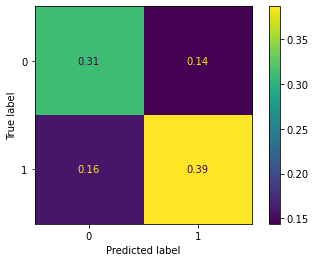

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

LogReg_cm = confusion_matrix(y_test, LogReg_pred, normalize='all')
LogReg_cmd = ConfusionMatrixDisplay(LogReg_cm)
LogReg_cmd.plot()

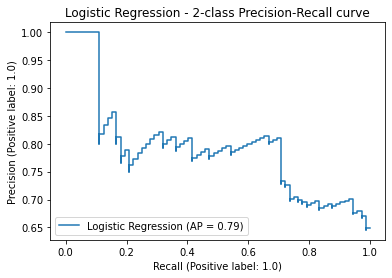

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    LogReg_search, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("Logistic Regression - 2-class Precision-Recall curve")

In [28]:
# Importing the model
from sklearn.svm import SVC

# Fitting and training
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [29]:
# Classifier predictions
svm_pred = svm_clf.predict(X_test)

#Printing out results
svm_report = classification_report(y_test, svm_pred)
print(svm_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=svm_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=svm_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.50      0.63        60
         1.0       0.69      0.93      0.79        72

    accuracy                           0.73       132
   macro avg       0.77      0.72      0.71       132
weighted avg       0.77      0.73      0.72       132



In [30]:
# Parameters to Tune
params = {"C": [.0001, .001,.01,0.1,1,2,5],
          "kernel":['rbf','sigmoid','linear'],
         'gamma': [0.001, 0.0001],}

svm_search = GridSearchCV(svm_clf, params, cv=5, return_train_score=True, verbose=5, scoring='f1_macro')

svm_search.fit(X,y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 5/5] END C=0.0001,

[CV 1/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.362, test=0.362) total time=   0.0s
[CV 1/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.733, test=0.741) total time=   0.1s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.753, test=0.727) total time=   0.6s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.777, test=0.575) total time=   0.2s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.739, test=0.737) total time=   0.0s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.822, test=0

[CV 4/5] END C=2, gamma=0.001, kernel=linear;, score=(train=0.742, test=0.737) total time=  17.3s
[CV 5/5] END C=2, gamma=0.001, kernel=linear;, score=(train=0.824, test=0.751) total time=   1.6s
[CV 1/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.901, test=0.759) total time=   0.0s
[CV 2/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.882, test=0.806) total time=   0.0s
[CV 3/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.887, test=0.837) total time=   0.0s
[CV 4/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.895, test=0.678) total time=   0.0s
[CV 5/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.878, test=0.808) total time=   0.0s
[CV 1/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.587, test=0.524) total time=   0.0s
[CV 2/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.518, test=0.383) total time=   0.0s
[CV 3/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.620, test=0.561) total time=   0.0s
[CV 4/5] END C=2, gamma=

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5],
                         'gamma': [0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_macro', verbose=5)

In [31]:
print("Best Accuracy: %f using %s" % (svm_search.best_score_, svm_search.best_params_))
print("Mean Training Score:", np.mean(svm_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", svm_search.score(X, y))
print("\nBest Parameter Found:")
svm_search.best_params_

Best Accuracy: 0.782537 using {'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}
Mean Training Score: 0.6129832751005507
Mean Testing Score: 0.9077006985378953

Best Parameter Found:


{'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}

In [32]:
svm_search = svm_search.best_estimator_

svm_search.fit(X_train, y_train)

SVC(C=5, gamma=0.0001)

In [33]:
# Classifier predictions
svm_pred = svm_search.predict(X_test)

#Printing out results
svm_report = classification_report(y_test, svm_pred)
print(svm_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=svm_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=svm_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84        60
         1.0       0.84      0.93      0.88        72

    accuracy                           0.86       132
   macro avg       0.87      0.86      0.86       132
weighted avg       0.87      0.86      0.86       132



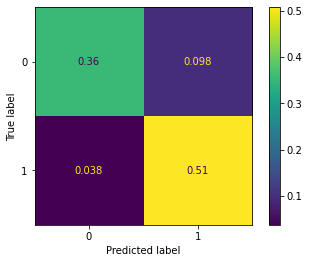

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

svm_cm = confusion_matrix(y_test, svm_pred, normalize='all')
svm_cmd = ConfusionMatrixDisplay(svm_cm)
svm_cmd.plot()

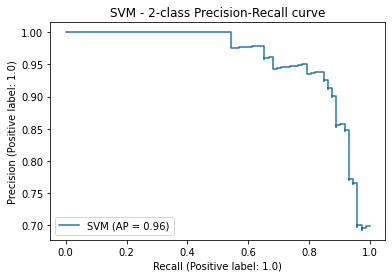

In [35]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    svm_search, X_test, y_test, name="SVM"
)
_ = display.ax_.set_title("SVM - 2-class Precision-Recall curve")

In [36]:
# Importing the model
from sklearn.neighbors import KNeighborsClassifier

# Fitting and training
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
# Classifier predictions
KNN_pred = KNN_clf.predict(X_test)

#Printing out results
KNN_report = classification_report(y_test, KNN_pred)
print(KNN_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=KNN_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=KNN_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.79        60
         1.0       0.80      0.89      0.84        72

    accuracy                           0.82       132
   macro avg       0.82      0.81      0.81       132
weighted avg       0.82      0.82      0.82       132



In [38]:
# Parameters to Tune
params = {"n_neighbors": [10, 20, 50, 200, 400, 600],
          "weights": ['uniform', 'distance'],
          "p": [1,2]}

KNN_search = GridSearchCV(KNN_clf, params, cv=5, return_train_score=True, verbose=5, scoring='f1_macro')

KNN_search.fit(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.850, test=0.761) total time=   0.0s
[CV 2/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.862, test=0.840) total time=   0.0s
[CV 3/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.853, test=0.759) total time=   0.0s
[CV 4/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.877, test=0.722) total time=   0.0s
[CV 5/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.871, test=0.770) total time=   0.0s
[CV 1/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.761) total time=   0.0s
[CV 2/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.828) total time=   0.0s
[CV 3/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.744) total time=   0.0s
[CV 4/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.686) total time=   0.0s
[CV 5/5

[CV 1/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END n_neighbors=400, p=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END n_neighbors=400, p=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END n_neighbors=400, p=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END n_neighbors=400, p=1, weights=distance;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END n_neighbors=400, p=1, weights=distance;, score=(train=nan, test=nan) total time=   

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 20, 50, 200, 400, 600],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1_macro', verbose=5)

In [39]:
print("Best Accuracy: %f using %s" % (KNN_search.best_score_, KNN_search.best_params_))
print("Mean Training Score:", np.mean(KNN_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", KNN_search.score(X, y))
print("\nBest Parameter Found:")
KNN_search.best_params_

Best Accuracy: 0.784678 using {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
Mean Training Score: nan
Mean Testing Score: 1.0

Best Parameter Found:


{'n_neighbors': 50, 'p': 1, 'weights': 'distance'}

In [40]:
# Classifier predictions
KNN_pred = KNN_search.predict(X_test)

#Printing out results
KNN_report = classification_report(y_test, KNN_pred)
print(KNN_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=KNN_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=KNN_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        72

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132



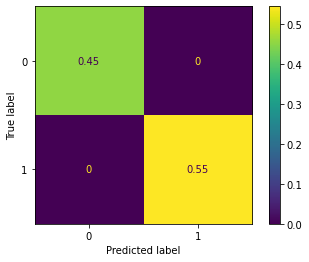

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

KNN_cm = confusion_matrix(y_test, KNN_pred, normalize='all')
KNN_cmd = ConfusionMatrixDisplay(KNN_cm)
KNN_cmd.plot()

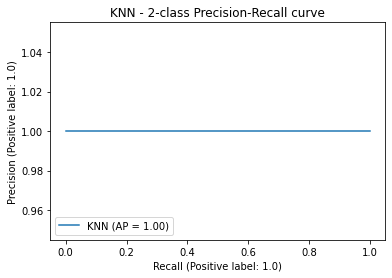

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    KNN_search, X_test, y_test, name="KNN"
)
_ = display.ax_.set_title("KNN - 2-class Precision-Recall curve")

In [43]:
# Importing the model
from sklearn.ensemble import RandomForestClassifier

# Fitting and training
RFC_clf = RandomForestClassifier()
RFC_clf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
# Classifier predictions
RFC_pred = RFC_clf.predict(X_test)

#Printing out results
RFC_report = classification_report(y_test, RFC_pred)
print(RFC_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=RFC_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=RFC_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90        60
         1.0       0.91      0.93      0.92        72

    accuracy                           0.91       132
   macro avg       0.91      0.91      0.91       132
weighted avg       0.91      0.91      0.91       132



In [45]:
# Parameters to Tune
params = {'n_estimators': [10,25,50,100,200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 2, 5, 10],
          'min_samples_split': [5,10],
          'min_samples_leaf': [1, 2, 5]}

RFC_search = GridSearchCV(RFC_clf, params, cv=5, return_train_score=True, verbose=5, scoring='f1_macro')

RFC_search.fit(X,y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.994, test=0.954) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.994, test=0.829) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.991, test=0.797) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.986, test=0.904) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.985, test=0.880) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=(train=0.997, test=0.953) total time=   0.0s
[CV 2/

[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.991, test=0.884) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.994, test=0.858) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.997, test=0.907) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.896) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.908) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.997, test=0.929) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_s

[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.985, test=0.848) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.991, test=0.965) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.980, test=0.867) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.980, test=0.907) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.991, test=0.896) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.985, test=0.908) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=5, mi

[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.896, test=0.882) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.926, test=0.931) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.908, test=0.711) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.908, test=0.853) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.947, test=0.853) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.899, test=0.870) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5,

[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.935, test=0.866) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.877, test=0.882) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.920, test=0.907) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.920, test=0.804) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.905, test=0.929) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.932, test=0.853) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=10

[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.912, test=0.904) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.941, test=0.853) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.869, test=0.760) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.890, test=0.824) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.898, test=0.776) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.878, test=0.798) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10

[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.980, test=0.787) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.977, test=0.881) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.980, test=0.879) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.977, test=0.907) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.983, test=0.851) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.988, test=0.896) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10

[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.983, test=0.896) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.980, test=0.904) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.962, test=0.853) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.977, test=0.918) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.983, test=0.874) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.983, test=0.873) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split

[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.871) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.971, test=0.929) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.977, test=0.866) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.977, test=0.907) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.977, test=0.885) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.980, test=0.895) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_sp

[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=1.000, test=0.885) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=1.000, test=0.908) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.953) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.866) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.980, test=0.885) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.997, test=0.863) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples

[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.977, test=0.965) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.983, test=0.880) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.977, test=0.918) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.985, test=0.907) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.985, test=0.873) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.980, test=0.953) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5

[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.908) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.997, test=0.907) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.904) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.879) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.930) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.897) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, mi

[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.997, test=0.879) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.919) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.931) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.920) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=1.000, test=0.942) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.994, test=0.879) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None,

[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.991, test=0.862) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.985, test=0.953) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.980, test=0.879) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.985, test=0.907) total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.985, test=0.885) total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.985, test=0.920) total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=None

[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.938, test=0.853) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.909, test=0.882) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.917, test=0.907) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.923, test=0.754) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.920, test=0.917) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.914, test=0.839) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=1,

[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.920, test=0.754) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.911, test=0.917) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.941, test=0.853) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=(train=0.895, test=0.861) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=(train=0.883, test=0.896) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=(train=0.905, test=0.747) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=2,

[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=(train=0.905, test=0.744) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=(train=0.885, test=0.866) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=(train=0.926, test=0.839) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.917, test=0.881) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.913, test=0.906) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.911, test=0.754) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=5,

[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.971, test=0.897) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.977, test=0.810) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.985, test=0.941) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.980, test=0.866) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.907) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.885) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=

[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.907) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.895) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.977, test=0.907) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.977, test=0.965) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.879) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.977, test=0.907) total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_l

[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.980, test=0.953) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.974, test=0.866) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.971, test=0.907) total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.983, test=0.908) total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.968, test=0.896) total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.977, test=0.953) total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_l

[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=1.000, test=0.885) total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=1.000, test=0.908) total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.941) total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.866) total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.991, test=0.919) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.997, test=0.885) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_sample

[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.991, test=0.892) total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=(train=0.968, test=0.906) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=(train=0.974, test=0.885) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=(train=0.974, test=0.826) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=(train=0.968, test=0.894) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=(train=0.968, test=0.830) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 25, 50, 100, 200]},
             return_train_score=True, scoring='f1_macro', verbose=5)

In [46]:
print("Best Accuracy: %f using %s" % (RFC_search.best_score_, RFC_search.best_params_))
print("Mean Training Score:", np.mean(RFC_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", RFC_search.score(X, y))
print("\nBest Parameter Found:")
RFC_search.best_params_

Best Accuracy: 0.919848 using {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Training Score: 0.9660377704774639
Mean Testing Score: 0.976682564917859

Best Parameter Found:


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [47]:
RFC_search = RFC_search.best_estimator_

RFC_search.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=200)

In [48]:
# Classifier predictions
RFC_pred = RFC_search.predict(X_test)

#Printing out results
RFC_report = classification_report(y_test, RFC_pred)
print(RFC_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=RFC_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=RFC_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.90        60
         1.0       0.90      0.96      0.93        72

    accuracy                           0.92       132
   macro avg       0.92      0.91      0.92       132
weighted avg       0.92      0.92      0.92       132



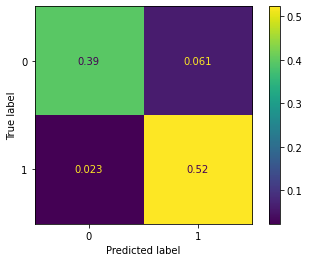

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

RFC_cm = confusion_matrix(y_test, RFC_pred, normalize='all')
RFC_cmd = ConfusionMatrixDisplay(RFC_cm)
RFC_cmd.plot()

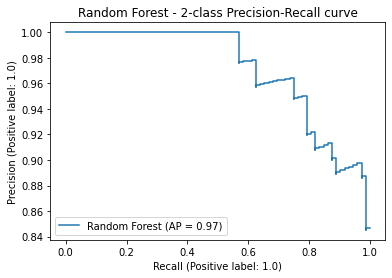

In [50]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    RFC_search, X_test, y_test, name="Random Forest"
)
_ = display.ax_.set_title("Random Forest - 2-class Precision-Recall curve")

In [51]:
from numpy import unique
from numpy import argmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier

In [52]:
# define the keras model

from sklearn.base import clone
 
def create_keras_classifier_model(n_classes):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=len(X.columns), activation='relu', kernel_initializer='normal'))
    model.add(Dense(n_classes, activation="softmax"))
    # Compile model
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model
 
estimator = KerasClassifier(build_fn=create_keras_classifier_model, n_classes=2)

In [53]:
estimator.fit(X_train, y_train)

# Classifier predictions
NN_pred = estimator.predict(X_test)

#Printing out results
NN_report = classification_report(y_test, NN_pred)
print(NN_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=NN_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=NN_pred))

10/10 [==============================] - 0s 1ms/step - loss: 3.5956 - accuracy: 0.7468
              precision    recall  f1-score   support

         0.0       0.71      0.48      0.57        60
         1.0       0.66      0.83      0.74        72

    accuracy                           0.67       132
   macro avg       0.68      0.66      0.66       132
weighted avg       0.68      0.67      0.66       132



In [54]:
# Parameters to Tune
params = {'epochs': [100,125,150,175,200],
          'batch_size': [5,10,20,30,40,50]}

NN_search = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=-1, cv=5, scoring='accuracy')

NN_search.fit(X,y)

Epoch 1/200
11/11 [==============================] - 0s 2ms/step - loss: 2.3726 - accuracy: 0.5932
Epoch 2/200
11/11 [==============================] - 0s 2ms/step - loss: 0.8745 - accuracy: 0.7091
Epoch 3/200
11/11 [==============================] - 0s 2ms/step - loss: 0.7993 - accuracy: 0.7432
Epoch 4/200
11/11 [==============================] - 0s 1ms/step - loss: 0.5336 - accuracy: 0.7614
Epoch 5/200
11/11 [==============================] - 0s 1ms/step - loss: 0.5186 - accuracy: 0.7682
Epoch 6/200
11/11 [==============================] - 0s 988us/step - loss: 0.5377 - accuracy: 0.7932
Epoch 7/200
11/11 [==============================] - 0s 1ms/step - loss: 0.5966 - accuracy: 0.7909
Epoch 8/200
11/11 [==============================] - 0s 963us/step - loss: 0.4564 - accuracy: 0.7977
Epoch 9/200
11/11 [==============================] - 0s 1ms/step - loss: 0.5301 - accuracy: 0.8091
Epoch 10/200
11/11 [==============================] - 0s 1ms/step - loss: 0.4967 - accuracy: 0.8114
Epoch

11/11 [==============================] - 0s 1ms/step - loss: 0.3454 - accuracy: 0.8591
Epoch 83/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8591
Epoch 84/200
11/11 [==============================] - 0s 1ms/step - loss: 0.5050 - accuracy: 0.8500
Epoch 85/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3214 - accuracy: 0.8591
Epoch 86/200
11/11 [==============================] - 0s 1ms/step - loss: 0.4137 - accuracy: 0.8500
Epoch 87/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3700 - accuracy: 0.8523
Epoch 88/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3341 - accuracy: 0.8568
Epoch 89/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3785 - accuracy: 0.8545
Epoch 90/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3268 - accuracy: 0.8591
Epoch 91/200
11/11 [==============================] - 0s 1ms/step - loss: 0.3117 - accuracy: 0.8614
Epoch 92/200


11/11 [==============================] - 0s 1ms/step - loss: 0.2598 - accuracy: 0.9000
Epoch 164/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2525 - accuracy: 0.8864
Epoch 165/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2725 - accuracy: 0.9045
Epoch 166/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2894 - accuracy: 0.8818
Epoch 167/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2614 - accuracy: 0.8841
Epoch 168/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2531 - accuracy: 0.9000
Epoch 169/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2488 - accuracy: 0.8977
Epoch 170/200
11/11 [==============================] - 0s 1ms/step - loss: 0.2525 - accuracy: 0.8864
Epoch 171/200
11/11 [==============================] - 0s 999us/step - loss: 0.2581 - accuracy: 0.8932
Epoch 172/200
11/11 [==============================] - 0s 986us/step - loss: 0.3909 - accuracy: 0.8818


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002B4998A8100>,
             n_jobs=-1,
             param_grid={'batch_size': [5, 10, 20, 30, 40, 50],
                         'epochs': [100, 125, 150, 175, 200]},
             scoring='accuracy')

In [55]:
print("Best Accuracy: %f using %s" % (NN_search.best_score_, NN_search.best_params_))
print("Mean Test Score:", np.mean(NN_search.cv_results_['mean_test_score']))
print("Mean Std. Test Score:", np.mean(NN_search.cv_results_['std_test_score']))
print("\nBest Parameter Found:")
NN_search.best_params_

Best Accuracy: 0.827273 using {'batch_size': 40, 'epochs': 200}
Mean Test Score: 0.8096212121212122
Mean Std. Test Score: 0.04372013744806823

Best Parameter Found:


{'batch_size': 40, 'epochs': 200}

In [56]:
NN_search = NN_search.best_estimator_

NN_search.fit(X_train, y_train)

Epoch 1/200
8/8 [==============================] - 0s 1ms/step - loss: 5.2697 - accuracy: 0.5909
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 3.2528 - accuracy: 0.5909
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 1.8171 - accuracy: 0.6331
Epoch 4/200
8/8 [==============================] - 0s 1ms/step - loss: 1.2551 - accuracy: 0.6721
Epoch 5/200
8/8 [==============================] - 0s 1ms/step - loss: 0.8817 - accuracy: 0.6981
Epoch 6/200
8/8 [==============================] - 0s 1ms/step - loss: 0.5971 - accuracy: 0.7630
Epoch 7/200
8/8 [==============================] - 0s 1ms/step - loss: 0.5120 - accuracy: 0.7695
Epoch 8/200
8/8 [==============================] - 0s 1ms/step - loss: 0.5536 - accuracy: 0.7727
Epoch 9/200
8/8 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7890
Epoch 10/200
8/8 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7890
Epoch 11/200
8/8 [===========

8/8 [==============================] - 0s 1ms/step - loss: 0.3623 - accuracy: 0.8766
Epoch 85/200
8/8 [==============================] - 0s 1ms/step - loss: 0.3313 - accuracy: 0.8799
Epoch 86/200
8/8 [==============================] - 0s 1ms/step - loss: 0.4960 - accuracy: 0.8636
Epoch 87/200
8/8 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.8766
Epoch 88/200
8/8 [==============================] - 0s 1ms/step - loss: 0.3370 - accuracy: 0.8831
Epoch 89/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2639 - accuracy: 0.8831
Epoch 90/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2826 - accuracy: 0.8831
Epoch 91/200
8/8 [==============================] - 0s 1ms/step - loss: 0.3466 - accuracy: 0.8766
Epoch 92/200
8/8 [==============================] - 0s 1ms/step - loss: 0.3237 - accuracy: 0.8799
Epoch 93/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2856 - accuracy: 0.8864
Epoch 94/200
8/8 [===============

8/8 [==============================] - 0s 1ms/step - loss: 0.2946 - accuracy: 0.8896
Epoch 168/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2436 - accuracy: 0.9156
Epoch 169/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2504 - accuracy: 0.9058
Epoch 170/200
8/8 [==============================] - 0s 1ms/step - loss: 0.3131 - accuracy: 0.9123
Epoch 171/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.9156
Epoch 172/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2820 - accuracy: 0.9058
Epoch 173/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2859 - accuracy: 0.9123
Epoch 174/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2329 - accuracy: 0.9123
Epoch 175/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2374 - accuracy: 0.9123
Epoch 176/200
8/8 [==============================] - 0s 1ms/step - loss: 0.2232 - accuracy: 0.9123
Epoch 177/200
8/8 [=====

In [57]:
# Classifier predictions
NN_pred = NN_search.predict(X_test)

#Printing out results
NN_report = classification_report(y_test, NN_pred)
print(NN_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=NN_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=NN_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84        60
         1.0       0.87      0.85      0.86        72

    accuracy                           0.85       132
   macro avg       0.85      0.85      0.85       132
weighted avg       0.85      0.85      0.85       132



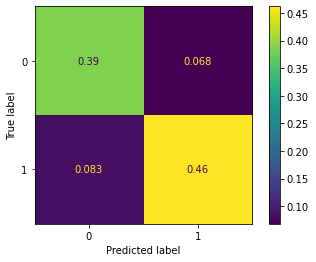

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
NN_cm = confusion_matrix(y_test, NN_pred, normalize='all')
NN_cmd = ConfusionMatrixDisplay(NN_cm)
NN_cmd.plot()

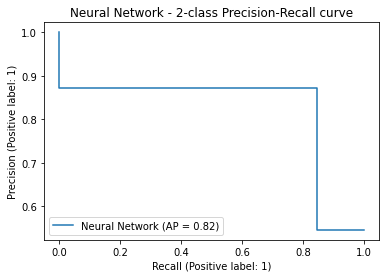

In [59]:
display = PrecisionRecallDisplay.from_predictions(y_test, NN_pred, name="Neural Network")
_ = display.ax_.set_title("Neural Network - 2-class Precision-Recall curve")

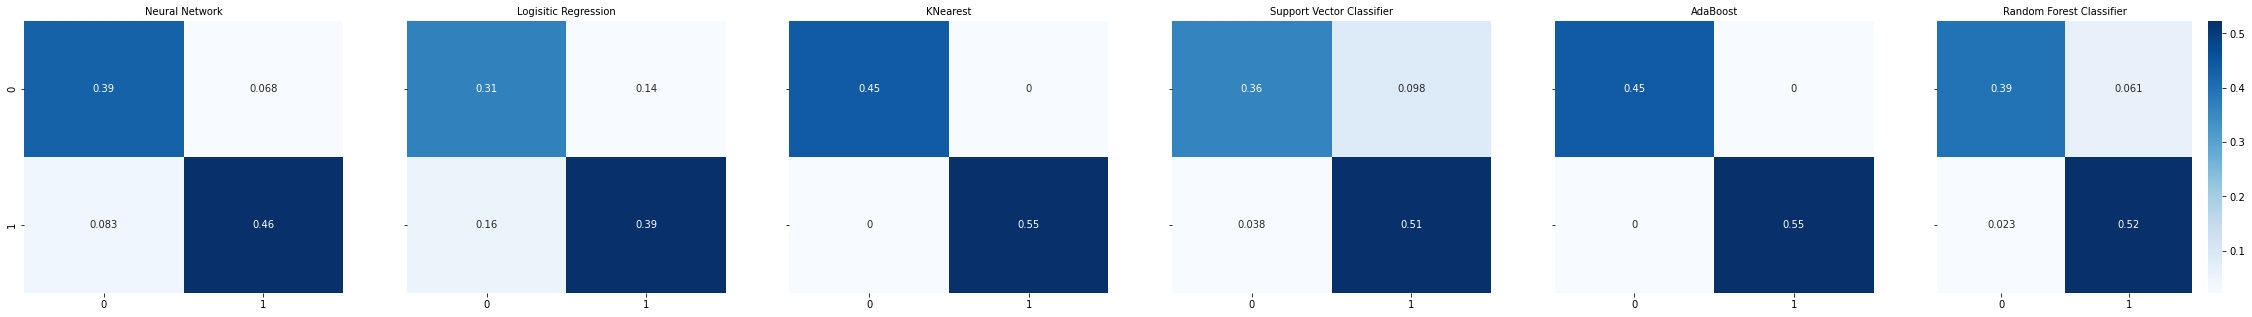

In [60]:
import seaborn as sns

classifiers = {
    "Neural Network": NN_cm,
    "Logisitic Regression": LogReg_cm,
    "KNearest": KNN_cm,
    "Support Vector Classifier": svm_cm,
    "AdaBoost": AdaBoost_cm,
    "Random Forest Classifier": RFC_cm,
}

fig, axn = plt.subplots(1,6, sharex=True, sharey=True,figsize=(40,5))

for i, ax in enumerate(axn.flat):
    k = list(classifiers)[i]
    sns.heatmap(classifiers[k], ax=ax, cbar=i==5, annot=True, cmap='Blues')
    ax.set_title(k,fontsize=10)

In [61]:
X = ['AdaBoost','Logistic Regression','SVM','KN Neighbour','Random Forest','Neural Network']
metrices = pd.DataFrame(zip(X, pre_optimization_precision,post_optimization_precision,
                            pre_optimization_accuracy, post_optimization_accuracy),
                        columns=['Classifier','Precision - Bf','Precision - Af','Accuracy - Bf','Accuracy - Af'])

metrices = metrices.sort_values('Precision - Af',ascending=False)
metrices

,Classifier,Precision - Bf,Precision - Af,Accuracy - Bf,Accuracy - Af
0,AdaBoost,1.000000,1.000000,1.000000,1.000000
3,KN Neighbour,0.800000,1.000000,0.818182,1.000000
4,Random Forest,0.905405,0.896104,0.909091,0.916667
5,Neural Network,0.659341,0.871429,0.674242,0.848485
2,SVM,0.690722,0.837500,0.734848,0.863636
1,Logistic Regression,0.739130,0.728571,0.704545,0.696970


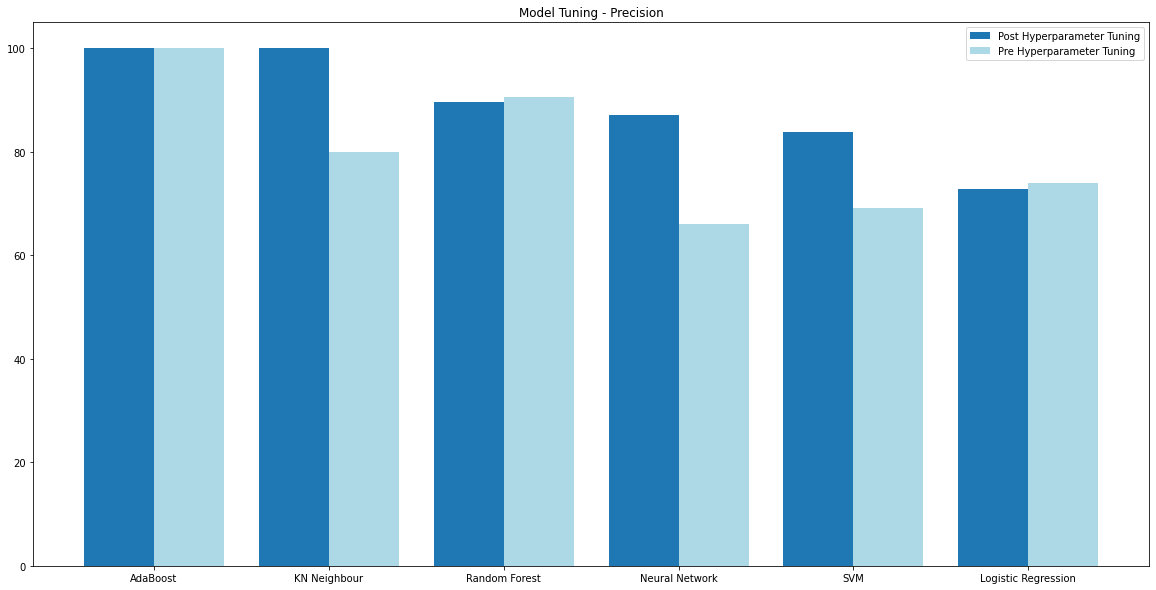

In [62]:
X_axis = np.arange(len(metrices))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, metrices['Precision - Af'] * 100, 0.4, label = 'Post Hyperparameter Tuning')
plt.bar(X_axis + 0.2, metrices['Precision - Bf'] * 100, 0.4, label = 'Pre Hyperparameter Tuning',
        color='lightblue')

plt.xticks(X_axis, metrices['Classifier'])
plt.title("Model Tuning - Precision")
plt.legend()
plt.show()

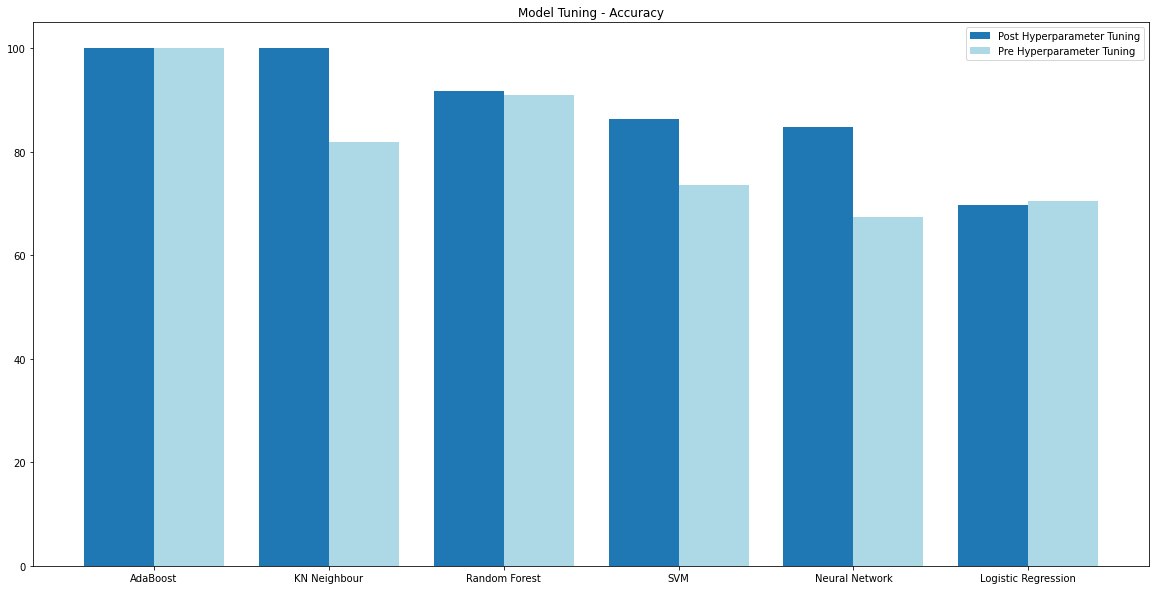

In [63]:
metrices = metrices.sort_values('Accuracy - Af',ascending=False)
  
X_axis = np.arange(len(metrices))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, metrices['Accuracy - Af'] * 100, 0.4, label = 'Post Hyperparameter Tuning')
plt.bar(X_axis + 0.2, metrices['Accuracy - Bf'] * 100, 0.4, label = 'Pre Hyperparameter Tuning',color='lightblue')
  
plt.xticks(X_axis, metrices['Classifier'])
plt.title("Model Tuning - Accuracy")
plt.legend()
plt.show()

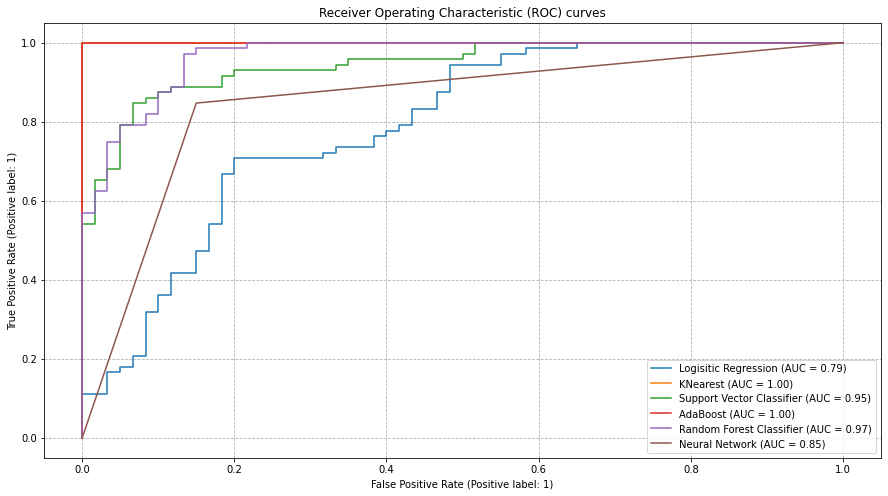

In [74]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers = {
    "Logisitic Regression": LogReg_search,
    "KNearest": KNN_search,
    "Support Vector Classifier": svm_search,
    "AdaBoost": AdaBoost_search,
    "Random Forest Classifier": RFC_search,
    "Neural Network": NN_search
}

# prepare plots
fig, ax_roc = plt.subplots(1, 1, figsize=(15, 8))

for name, clf in classifiers.items():

    try:
        RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
        #DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)
    except ValueError:
        RocCurveDisplay.from_predictions(y_pred=NN_pred, y_true=y_test, ax=ax_roc, name=name)
        #DetCurveDisplay.from_predictions(y_pred=NN_pred, y_true=y_test, ax=ax_det, name=name)        

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
#ax_det.grid(linestyle="--")

plt.legend()
plt.show()